In [7]:
# Import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.pgn
from io import StringIO
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from functions import fetch_json, fetch_all_games, write_games_to_csv, board_to_features, play_game_against_stockfish, calculate_elo, calculate_stockfish_elo, calculate_and_print_stats

In [3]:
# URL to fetch all game archives for Hikaru
archives_url = "https://api.chess.com/pub/player/hikaru/games/archives"

# Fetch archive URLs
archives_data = fetch_json(archives_url)
archive_urls = archives_data['archives']

# Fetch all games
all_games = fetch_all_games(archive_urls)

# Write games to CSV
write_games_to_csv(all_games, 'hikaru_all_games.csv')

print(f"Total number of games: {len(all_games)}")

Fetched 44 games from https://api.chess.com/pub/player/hikaru/games/2014/01
Fetched 54 games from https://api.chess.com/pub/player/hikaru/games/2014/02
Fetched 162 games from https://api.chess.com/pub/player/hikaru/games/2014/03
Fetched 23 games from https://api.chess.com/pub/player/hikaru/games/2014/04
Fetched 494 games from https://api.chess.com/pub/player/hikaru/games/2014/05
Fetched 16 games from https://api.chess.com/pub/player/hikaru/games/2014/06
Fetched 5 games from https://api.chess.com/pub/player/hikaru/games/2014/07
Fetched 253 games from https://api.chess.com/pub/player/hikaru/games/2014/08
Fetched 287 games from https://api.chess.com/pub/player/hikaru/games/2014/09
Fetched 10 games from https://api.chess.com/pub/player/hikaru/games/2014/10
Fetched 270 games from https://api.chess.com/pub/player/hikaru/games/2014/11
Fetched 161 games from https://api.chess.com/pub/player/hikaru/games/2014/12
Fetched 261 games from https://api.chess.com/pub/player/hikaru/games/2015/01
Fetche

Total games: 57799
Win rate: 79.09%
Draw rate: 2.81%
Loss rate: 18.10%

As White:
Total games as White: 29136
Win rate: 80.93%
Draw rate: 2.59%
Loss rate: 16.47%

As Black:
Total games as Black: 28663
Win rate: 77.22%
Draw rate: 3.04%
Loss rate: 19.74%


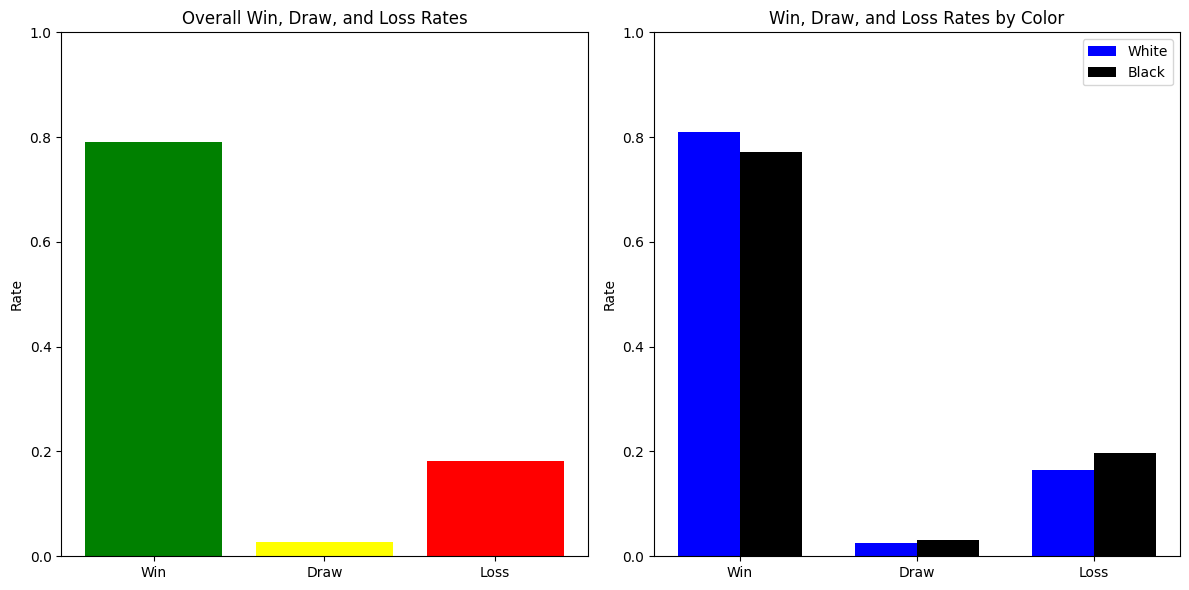

In [2]:

# Load the CSV data
filename = 'hikaru_all_games.csv'
df = pd.read_csv(filename)

# Calculate and print statistics
(win_rate, draw_rate, loss_rate, white_win_rate, white_draw_rate, white_loss_rate, black_win_rate, black_draw_rate, black_loss_rate) = calculate_and_print_stats(df)

# Plot overall win, draw, and loss rates
labels = ['Win', 'Draw', 'Loss']
overall_rates = [win_rate, draw_rate, loss_rate]
white_rates = [white_win_rate, white_draw_rate, white_loss_rate]
black_rates = [black_win_rate, black_draw_rate, black_loss_rate]

x = range(len(labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Overall plot
ax[0].bar(x, overall_rates, color=['green', 'yellow', 'red'])
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Rate')
ax[0].set_title('Overall Win, Draw, and Loss Rates')

# Win rates by color
bar_width = 0.35
ax[1].bar(x, white_rates, bar_width, label='White', color='blue')
ax[1].bar([p + bar_width for p in x], black_rates, bar_width, label='Black', color='black')
ax[1].set_xticks([p + bar_width / 2 for p in x])
ax[1].set_xticklabels(labels)
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Rate')
ax[1].set_title('Win, Draw, and Loss Rates by Color')
ax[1].legend()

plt.tight_layout()
plt.show()

In [5]:
# Prepare the dataset for training
X, y = [], []
successful_parses = 0
total_games = len(df)

for index, row in df.iterrows():
    result, color, moves = row['Result'], row['Color'], row['Moves']
    pgn_str = f"[Result \"{result}\"]\n1. {moves.replace(' ', ' 1. ')}"
    
    try:
        game = chess.pgn.read_game(StringIO(pgn_str))
        if game is None:
            continue  # Skip if the game cannot be parsed
        board = game.board()
        
        for move in game.mainline_moves():
            if (board.turn == chess.WHITE and color == 'white') or (board.turn == chess.BLACK and color == 'black'):
                X.append(board_to_features(board))
                y.append(move.uci())
            board.push(move)
        successful_parses += 1
    except Exception as e:
        print(f"Error parsing game at index {index}: {e}")
        continue  # Skip games that cannot be parsed

# Print the number of successfully parsed games and the success percentage
print(f"Successfully parsed games: {successful_parses}")
print(f"Total games: {total_games}")
print(f"Success percentage: {successful_parses / total_games * 100:.2f}%")

# Convert to numpy arrays and ensure correct data types
X = np.array(X, dtype=np.float32)
y = np.array(y)

# Debugging statements to check shapes and types
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Type of X: {type(X)}")
print(f"Type of y: {type(y)}")

# Encode the moves
unique_moves = sorted(set(y))
move_encoder = {uci: idx for idx, uci in enumerate(unique_moves)}
y_encoded = np.array([move_encoder[uci] for uci in y], dtype=np.int32)

# Check the encoding
print(f"Unique moves: {len(unique_moves)}")
print(f"Example encoded move: {y_encoded[0]}")


illegal san: 'c6' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 while parsing <Game at 0x15bc15650 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'd5' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 while parsing <Game at 0x15be6ec90 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Kd8' in r1bqkbnr/ppNppppp/8/2p5/2Pn4/8/PP1PPPPP/R1BQKBNR b KQkq - 5 4 while parsing <Game at 0x15bbf2010 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ne3' in rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2 while parsing <Game at 0x1680408d0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Nb3' in r2qkbnr/1bpppp1p/ppn3p1/8/PP4P1/2N5/2PPPPBP/R1BQK1NR w KQkq - 0 6 while parsing <Game at 0x28e45b610 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Nfe6' in rnbqkbnr/pppp1ppp/8/4p3/2B1P3/8/PPPP1PPP/RNBQK1NR b KQkq - 1 2 while parsing <Game at 0x29ecfea10 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Nab6' in rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq -

Successfully parsed games: 57799
Total games: 57799
Success percentage: 100.00%
Shape of X: (2404111, 8, 8, 12)
Shape of y: (2404111,)
Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.ndarray'>
Unique moves: 1878
Example encoded move: 985


In [8]:
# Define the model
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 12), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(len(move_encoder), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/williambogdanovic/Desktop/chess/hikaru-chess-model/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 974,486 (3.72 MB)

 Trainable params: 972,054 (3.71 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Train the model with enhanced training process
history = model.fit(
    X, y_encoded,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the model
model.save('models/hikaru_chess_model_v3.h5')
# Save the move encoder
np.save('models/move_encoder_classes_v3.npy', np.array(list(move_encoder.keys())))

Now that we trained a model, we will test its rating and print out the estimated ELO using Stockfish duels across 50 games.
This part is not necessary, which is why I don't include the stockfish build in repo, but you can download it from [here](https://stockfishchess.org/download/).

The code below will run the stockfish duels and print out the estimated ELO of the model.
We see that the model has an estimated ELO of 1500.

In [12]:
# Load the saved model
model = tf.keras.models.load_model('models/hikaru_chess_model_v2.h5')

# Load the move encoder
move_encoder_keys = np.load('models/move_encoder_classes_v2.npy', allow_pickle=True)
move_encoder = {uci: idx for idx, uci in enumerate(move_encoder_keys)}

# Path to the Stockfish executable
stockfish_path = "stockfish/Stockfish-master/src/stockfish"

# Calculate Elo rating for Stockfish against itself
calculate_stockfish_elo(stockfish_path, num_games=50, stockfish_level=1)

# Calculate Elo rating
calculate_elo(model, move_encoder, stockfish_path, num_games=50, stockfish_level=1)

Wins: 23, Losses: 25, Draws: 2
Estimated Elo rating for Stockfish: 2399.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━